In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Markowitz Minimum Variance Portfolio

This notebook implements the **Markowitz Minimum Variance Optimization** using the same 30 stocks from the S&P 500.

In [40]:
# Load data
path = "data/SPX_database_2010.xlsx"
df_total_ret = pd.read_excel(path, sheet_name='total_ret')

In [41]:
# Clean column names
def clean_column_names(df):
    """Extract ticker symbols from column names like 'ABBV UN Equity' -> 'ABBV'"""
    new_columns = []
    for col in df.columns:
        if ' UN Equity' in str(col):
            ticker = col.split(' UN Equity')[0]
            new_columns.append(ticker)
        elif ' UW Equity' in str(col):
            ticker = col.split(' UW Equity')[0]
            new_columns.append(ticker)
        else:
            new_columns.append(col)
    return new_columns

df_total_ret.columns = clean_column_names(df_total_ret)
print("Column names cleaned successfully")

Column names cleaned successfully


In [42]:
# Select the same 30 stocks
tickers = [
    "MSFT", "AAPL", "NVDA", "GOOGL", "IBM",
    "AVGO", "ADBE", "CRM", "INTC", "INTU",
    "UNH", "PFE", "LLY", "ABT", "MRK",
    "MCD", "AMZN", "COST", "SBUX", "PG",
    "JPM", "GS", "MS", "BLK", "CAT",
    "DE", "GE", "XOM", "NEE", "ETN"
]

df_total_ret = df_total_ret[['Dates'] + tickers]
df_total_ret.set_index('Dates', inplace=True)
df_total_ret = df_total_ret.loc[:, ~df_total_ret.columns.duplicated()]

print(f"Selected {len(tickers)} stocks")
df_total_ret.head()

Selected 30 stocks


,MSFT,AAPL,NVDA,GOOGL,IBM,AVGO,ADBE,CRM,INTC,INTU,...,JPM,GS,MS,BLK,CAT,DE,GE,XOM,NEE,ETN
Dates,,,,,,,,,,,,,,,,,,,,,
2010-01-01,37.2233,7.5307,0.4670,15.515,138.9694,1.829,37.034,18.4425,23.2758,30.71,...,58.4516,183.162,35.7589,257.763,73.9167,65.9404,96.9910,84.7537,18.9076,40.5340
2010-01-04,37.7849,7.6493,0.4622,15.684,140.6150,1.886,37.346,18.7050,23.8235,30.81,...,60.1769,187.762,37.3415,264.846,75.9401,68.3420,99.0424,85.9468,19.0616,40.9799
2010-01-05,37.7971,7.6564,0.4690,15.615,138.9164,1.900,37.960,18.6250,23.8121,30.81,...,61.3425,191.081,38.7066,265.989,76.8480,68.0860,99.5552,86.2824,18.8754,40.7378
2010-01-06,37.5651,7.5346,0.4720,15.221,138.0140,1.915,37.880,18.5925,23.7322,30.38,...,61.6796,189.042,39.2019,260.505,77.0815,67.9031,99.0424,87.0282,19.0616,40.5594
2010-01-07,37.2111,7.5207,0.4628,14.867,137.5362,1.903,37.145,18.5100,23.5040,30.28,...,62.9014,192.741,39.7697,263.369,77.3927,68.3908,104.1708,86.7547,19.0079,41.1583


In [43]:
# Calculate daily returns
df_daily_ret = df_total_ret.pct_change().dropna()

print("Daily returns shape:", df_daily_ret.shape)
print("Number of stocks:", len(df_daily_ret.columns))
df_daily_ret.head()

Daily returns shape: (4065, 30)
Number of stocks: 30


,MSFT,AAPL,NVDA,GOOGL,IBM,AVGO,ADBE,CRM,INTC,INTU,...,JPM,GS,MS,BLK,CAT,DE,GE,XOM,NEE,ETN
Dates,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.015087,0.015749,-0.010278,0.010893,0.011841,0.031165,0.008425,0.014233,0.023531,0.003256,...,0.029517,0.025114,0.044258,0.027479,0.027374,0.036421,0.021150,0.014077,0.008145,0.011001
2010-01-05,0.000323,0.000928,0.014712,-0.004399,-0.012080,0.007423,0.016441,-0.004277,-0.000479,0.000000,...,0.019370,0.017677,0.036557,0.004316,0.011955,-0.003746,0.005178,0.003905,-0.009768,-0.005908
2010-01-06,-0.006138,-0.015908,0.006397,-0.025232,-0.006496,0.007895,-0.002107,-0.001745,-0.003355,-0.013957,...,0.005495,-0.010671,0.012796,-0.020617,0.003038,-0.002686,-0.005151,0.008644,0.009865,-0.004379
2010-01-07,-0.009424,-0.001845,-0.019492,-0.023257,-0.003462,-0.006266,-0.019403,-0.004437,-0.009616,-0.003292,...,0.019809,0.019567,0.014484,0.010994,0.004037,0.007182,0.051780,-0.003143,-0.002817,0.014766
2010-01-08,0.005904,0.006648,0.002161,0.013318,0.010035,0.007357,-0.005438,0.001486,0.011164,0.026420,...,-0.002456,-0.018911,-0.020352,0.007040,0.011228,0.027273,0.021539,-0.004011,-0.008665,0.022447


In [44]:
# Load SOFR (risk-free rate) data
df_sofr = pd.read_excel("data/SOFR.xlsx")
df_sofr.rename(columns={"Data": "Dates"}, inplace=True)
df_sofr["Dates"] = pd.to_datetime(df_sofr["Dates"]) 
df_sofr = df_sofr.set_index("Dates").sort_index()
df_sofr["Taxa_diaria"] = ((1 + df_sofr["Price"]) ** (1/252)) - 1
df_sofr = df_sofr[(df_sofr.index.year >= 2000)]

print("SOFR data loaded successfully")
print(f"Date range: {df_sofr.index.min()} to {df_sofr.index.max()}")
print(f"\nFirst few rows:")
df_sofr.head()

SOFR data loaded successfully
Date range: 2014-01-02 00:00:00 to 2025-08-01 00:00:00

First few rows:


,Price,Taxa_diaria
Dates,,
2014-01-02,0.0005,0.000002
2014-01-03,0.0005,0.000002
2014-01-06,0.0005,0.000002
2014-01-07,0.0004,0.000002
2014-01-08,0.0004,0.000002


## Calculate Covariance Matrix

The covariance matrix is essential for Markowitz optimization as it captures the relationships between stock returns.

In [45]:
# Calculate covariance matrix (annualized)
cov_matrix = df_daily_ret.cov() * 252

print("Covariance Matrix Shape:", cov_matrix.shape)
print("\nFirst few rows and columns:")
print(cov_matrix.iloc[:5, :5])

Covariance Matrix Shape: (30, 30)

First few rows and columns:
           MSFT      AAPL      NVDA     GOOGL       IBM
MSFT   0.063502  0.041284  0.064488  0.043148  0.024295
AAPL   0.041284  0.077317  0.060987  0.041230  0.024108
NVDA   0.064488  0.060987  0.203966  0.061256  0.032894
GOOGL  0.043148  0.041230  0.061256  0.073425  0.022877
IBM    0.024295  0.024108  0.032894  0.022877  0.049651


## Markowitz Minimum Variance Optimization

We'll minimize portfolio variance subject to the constraint that weights sum to 1.

In [46]:
def portfolio_variance(weights, cov_matrix):
    """Calculate portfolio variance"""
    return weights.T @ cov_matrix @ weights

def minimize_variance(cov_matrix):
    """
    Find the minimum variance portfolio weights
    
    Parameters:
    -----------
    cov_matrix : pd.DataFrame
        Covariance matrix of returns
    
    Returns:
    --------
    weights : np.array
        Optimal portfolio weights
    """
    num_assets = len(cov_matrix)
    
    # Initial guess (equal weights)
    initial_weights = np.array([1/num_assets] * num_assets)
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds: weights between 0 and 1 (long-only portfolio)
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Minimize variance
    result = minimize(
        portfolio_variance,
        initial_weights,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x

# Find optimal weights
optimal_weights = minimize_variance(cov_matrix)

print("Optimization successful!")
print(f"\nNumber of non-zero weights: {np.sum(optimal_weights > 0.0001)}")
print(f"Sum of weights: {np.sum(optimal_weights):.6f}")
print(f"\nPortfolio variance: {portfolio_variance(optimal_weights, cov_matrix):.6f}")
print(f"Portfolio volatility (annual): {np.sqrt(portfolio_variance(optimal_weights, cov_matrix)):.2%}")

Optimization successful!

Number of non-zero weights: 12
Sum of weights: 1.000000

Portfolio variance: 0.018164
Portfolio volatility (annual): 13.48%


In [47]:
# Display optimal weights
weights_df = pd.DataFrame({
    'Stock': df_daily_ret.columns,
    'Weight': optimal_weights
}).sort_values('Weight', ascending=False)

print("Optimal Portfolio Weights:")
print("=" * 40)
print(weights_df[weights_df['Weight'] > 0.0001].to_string(index=False))
print("=" * 40)

Optimal Portfolio Weights:
Stock   Weight
   PG 0.251575
  MCD 0.205788
 COST 0.146016
  MRK 0.087068
  PFE 0.085509
  XOM 0.063367
  NEE 0.053870
  IBM 0.037080
  LLY 0.036379
 AMZN 0.017290
  ABT 0.010541
GOOGL 0.005517


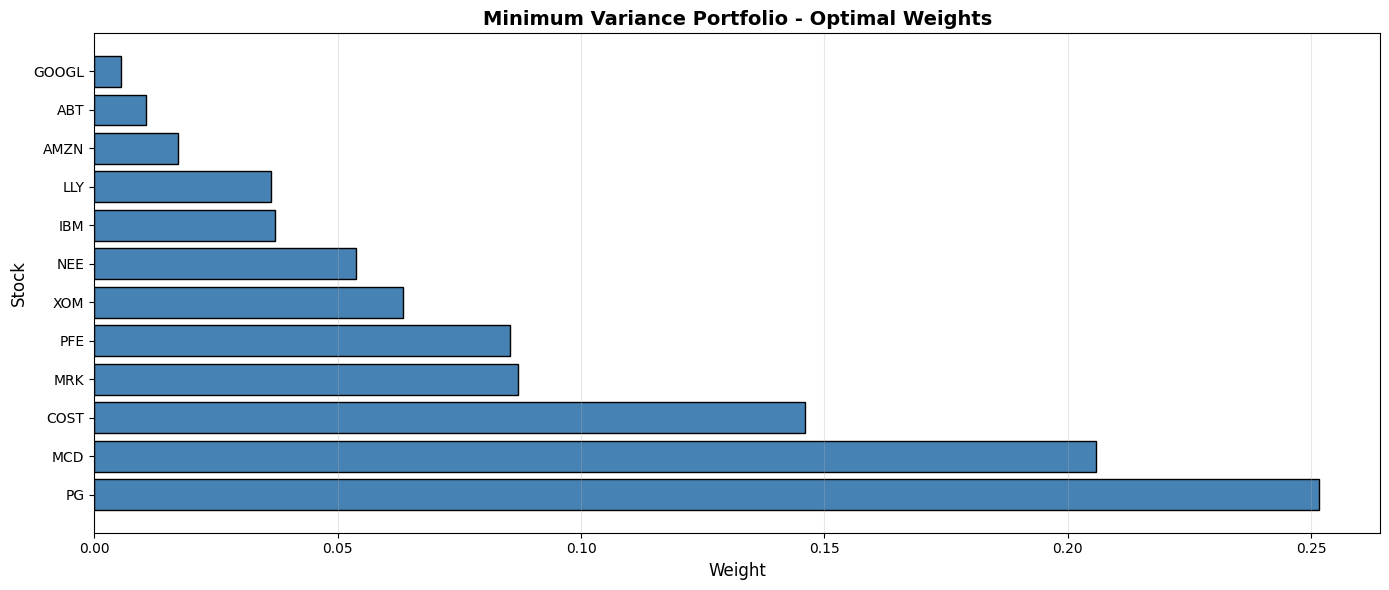

In [48]:
# Visualize weights
plt.figure(figsize=(14, 6))
weights_plot = weights_df[weights_df['Weight'] > 0.0001].copy()
plt.barh(weights_plot['Stock'], weights_plot['Weight'], color='steelblue', edgecolor='black')
plt.xlabel('Weight', fontsize=12)
plt.ylabel('Stock', fontsize=12)
plt.title('Minimum Variance Portfolio - Optimal Weights', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Calculate Portfolio Performance

In [49]:
def min_variance_portfolio(df_daily_returns, weights):
    """
    Calculate minimum variance portfolio performance using daily returns and optimal weights.
    
    Parameters:
    -----------
    df_daily_returns : pd.DataFrame
        DataFrame with daily returns for each stock
    weights : np.array
        Optimal portfolio weights
    
    Returns:
    --------
    portfolio : pd.DataFrame
        DataFrame with portfolio daily returns, cumulative value, and cumulative return
    """
    portfolio = pd.DataFrame(index=df_daily_returns.index)
    
    # Calculate portfolio daily returns as weighted sum of stock returns
    portfolio['Daily Return'] = df_daily_returns.mul(weights).sum(axis=1)
    
    # Calculate cumulative portfolio value (starting from 1)
    portfolio['Portfolio Value'] = (1 + portfolio['Daily Return']).cumprod()
    
    # Calculate cumulative return
    portfolio['Cumulative Return'] = portfolio['Portfolio Value'] - 1
    
    return portfolio

# Create the minimum variance portfolio
mvo_portfolio = min_variance_portfolio(df_daily_ret, optimal_weights)

print("Portfolio Statistics:")
print(f"Initial Value: {mvo_portfolio['Portfolio Value'].iloc[0]:.4f}")
print(f"Final Value: {mvo_portfolio['Portfolio Value'].iloc[-1]:.4f}")
print(f"Total Return: {mvo_portfolio['Cumulative Return'].iloc[-1]:.2%}")
print(f"\nFirst few rows:")
mvo_portfolio.head()

Portfolio Statistics:
Initial Value: 1.0103
Final Value: 7.7019
Total Return: 670.19%

First few rows:


,Daily Return,Portfolio Value,Cumulative Return
Dates,,,
2010-01-04,0.010299,1.010299,0.010299
2010-01-05,-0.004173,1.006083,0.006083
2010-01-06,-0.000492,1.005588,0.005588
2010-01-07,-0.001745,1.003834,0.003834
2010-01-08,-0.000970,1.002860,0.002860


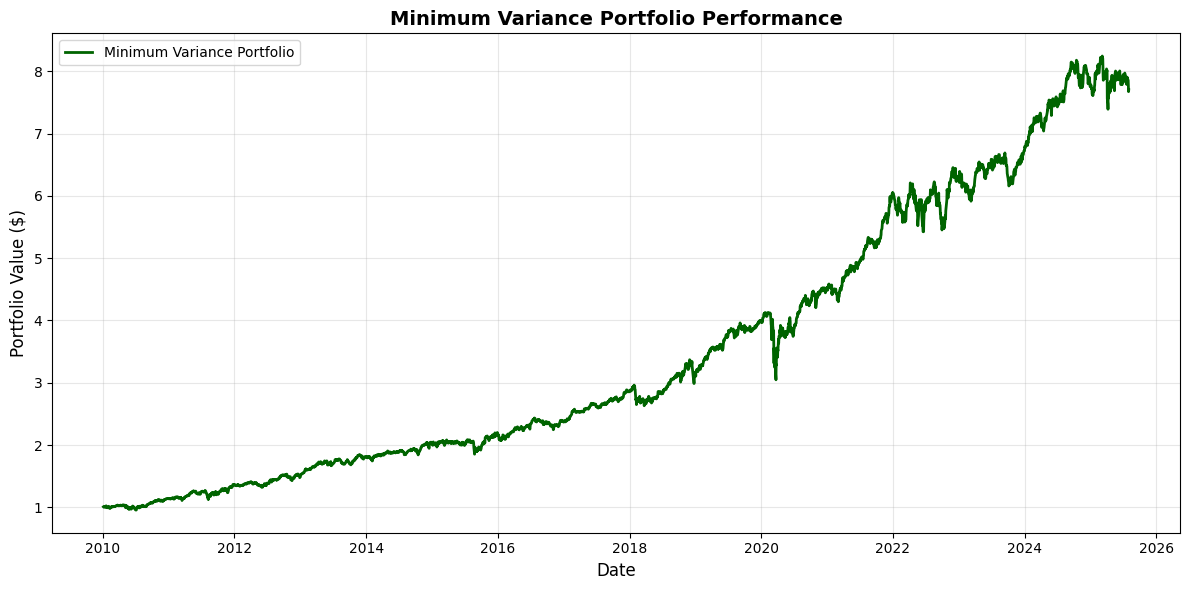

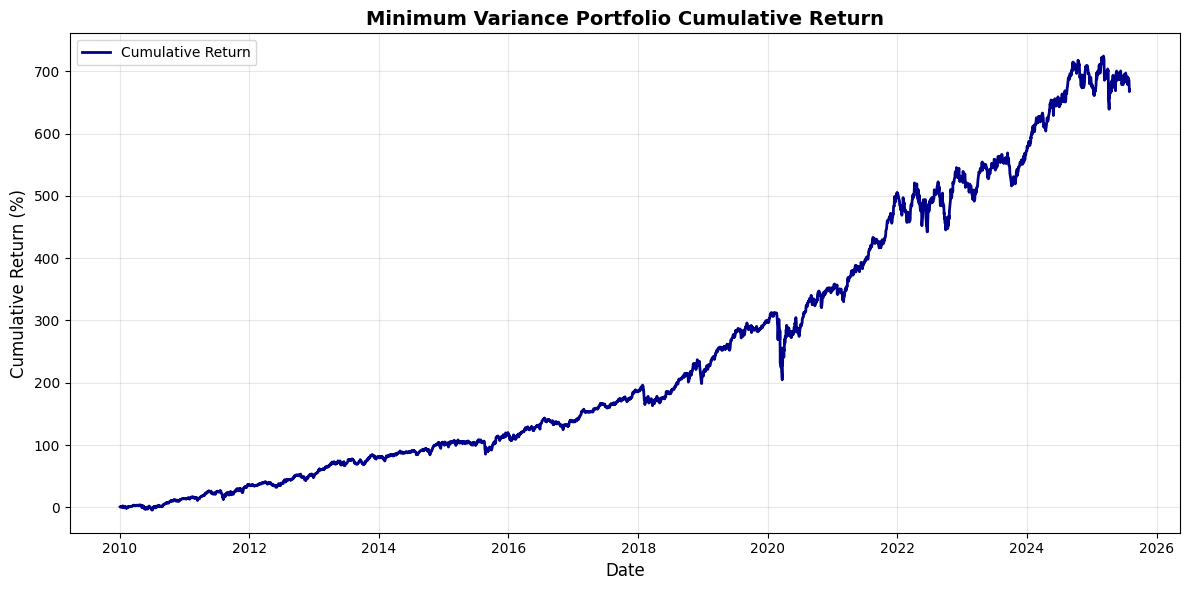

In [50]:
# Visualize portfolio performance

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(mvo_portfolio.index, mvo_portfolio['Portfolio Value'], 
         label='Minimum Variance Portfolio', color='darkgreen', linewidth=2)
plt.title('Minimum Variance Portfolio Performance', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(mvo_portfolio.index, mvo_portfolio['Cumulative Return'] * 100, 
         label='Cumulative Return', color='darkblue', linewidth=2)
plt.title('Minimum Variance Portfolio Cumulative Return', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Portfolio Performance Metrics

In [55]:
def calculate_portfolio_metrics(portfolio, rf_daily_series=None):
    """Calculate key performance metrics for the portfolio
    
    Parameters:
    -----------
    portfolio : pd.DataFrame
        DataFrame with portfolio daily returns
    rf_daily_series : pd.Series, optional
        Series with daily risk-free rates aligned to portfolio dates
        If None, uses a fixed 3% annual rate
    """
    
    # Annualized return
    daily_returns = portfolio['Daily Return']
    annualized_return = daily_returns.mean() * 252
    
    # Annualized volatility (standard deviation)
    annualized_vol = daily_returns.std() * (252 ** 0.5)
    
    # Sharpe ratio
    if rf_daily_series is not None:
        # Use actual risk-free rates aligned with portfolio dates
        common_dates = daily_returns.index.intersection(rf_daily_series.index)
        excess_returns = daily_returns.loc[common_dates] - rf_daily_series.loc[common_dates]
        sharpe_ratio = (excess_returns.mean() * 252) / (daily_returns.loc[common_dates].std() * (252 ** 0.5))
    else:
        # Fall back to fixed 3% annual rate
        r_rf_annual = 0.03
        r_rf_daily = r_rf_annual / 252
        excess_returns = daily_returns - r_rf_daily
        sharpe_ratio = (excess_returns.mean() * 252) / (daily_returns.std() * (252 ** 0.5))
    
    # Total return
    total_return = portfolio['Cumulative Return'].iloc[-1]
    
    # Max drawdown
    cumulative = (1 + daily_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_vol,
        'Sharpe Ratio': sharpe_ratio,
        'Total Return': total_return,
        'Max Drawdown': max_drawdown
    }

# Align SOFR data with portfolio dates
rf_daily = df_sofr['Taxa_diaria'].reindex(mvo_portfolio.index, method='ffill')

# Calculate metrics using actual SOFR rates
mvo_metrics = calculate_portfolio_metrics(mvo_portfolio, rf_daily)

print("=" * 50)
print("MINIMUM VARIANCE PORTFOLIO METRICS")
print("(Using SOFR as Risk-Free Rate)")
print("=" * 50)
for metric, value in mvo_metrics.items():
    if 'Return' in metric or 'Drawdown' in metric or 'Volatility' in metric:
        print(f"{metric:.<30} {value:>8.2%}")
    else:
        print(f"{metric:.<30} {value:>8.2f}")
print("=" * 50)

MINIMUM VARIANCE PORTFOLIO METRICS
(Using SOFR as Risk-Free Rate)
Annualized Return.............   13.57%
Annualized Volatility.........   13.48%
Sharpe Ratio..................     0.84
Total Return..................  670.19%
Max Drawdown..................  -26.14%


## Compare with Equally Weighted Portfolio

In [52]:
# Create equally weighted portfolio for comparison
def equally_weighted_portfolio(df_daily_returns):
    """Calculate equally weighted portfolio performance"""
    portfolio = pd.DataFrame(index=df_daily_returns.index)
    num_stocks = len(df_daily_returns.columns)
    weight = 1 / num_stocks
    portfolio['Daily Return'] = df_daily_returns.mul(weight).sum(axis=1)
    portfolio['Portfolio Value'] = (1 + portfolio['Daily Return']).cumprod()
    portfolio['Cumulative Return'] = portfolio['Portfolio Value'] - 1
    return portfolio

ew_portfolio = equally_weighted_portfolio(df_daily_ret)

# Align SOFR data with equally weighted portfolio dates
rf_daily_ew = df_sofr['Taxa_diaria'].reindex(ew_portfolio.index, method='ffill')

# Calculate metrics using actual SOFR rates
ew_metrics = calculate_portfolio_metrics(ew_portfolio, rf_daily_ew)

# Comparison table
print("\n" + "=" * 75)
print("PORTFOLIO COMPARISON: MINIMUM VARIANCE vs EQUALLY WEIGHTED")
print("(Using SOFR as Risk-Free Rate)")
print("=" * 75)
print(f"{'Metric':<30} {'Min Variance':>18} {'Equal Weight':>18} {'Difference':>12}")
print("-" * 75)

for metric in mvo_metrics.keys():
    mvo_val = mvo_metrics[metric]
    ew_val = ew_metrics[metric]
    diff = mvo_val - ew_val
    
    if 'Return' in metric or 'Drawdown' in metric or 'Volatility' in metric:
        print(f"{metric:<30} {mvo_val:>17.2%} {ew_val:>17.2%} {diff:>11.2%}")
    else:
        print(f"{metric:<30} {mvo_val:>17.2f} {ew_val:>17.2f} {diff:>11.2f}")
print("=" * 75)


PORTFOLIO COMPARISON: MINIMUM VARIANCE vs EQUALLY WEIGHTED
(Using SOFR as Risk-Free Rate)
Metric                               Min Variance       Equal Weight   Difference
---------------------------------------------------------------------------
Annualized Return                         13.57%            19.03%      -5.46%
Annualized Volatility                     13.48%            17.85%      -4.37%
Sharpe Ratio                                0.84              0.98       -0.14
Total Return                             670.19%          1561.91%    -891.72%
Max Drawdown                             -26.14%           -32.42%       6.27%


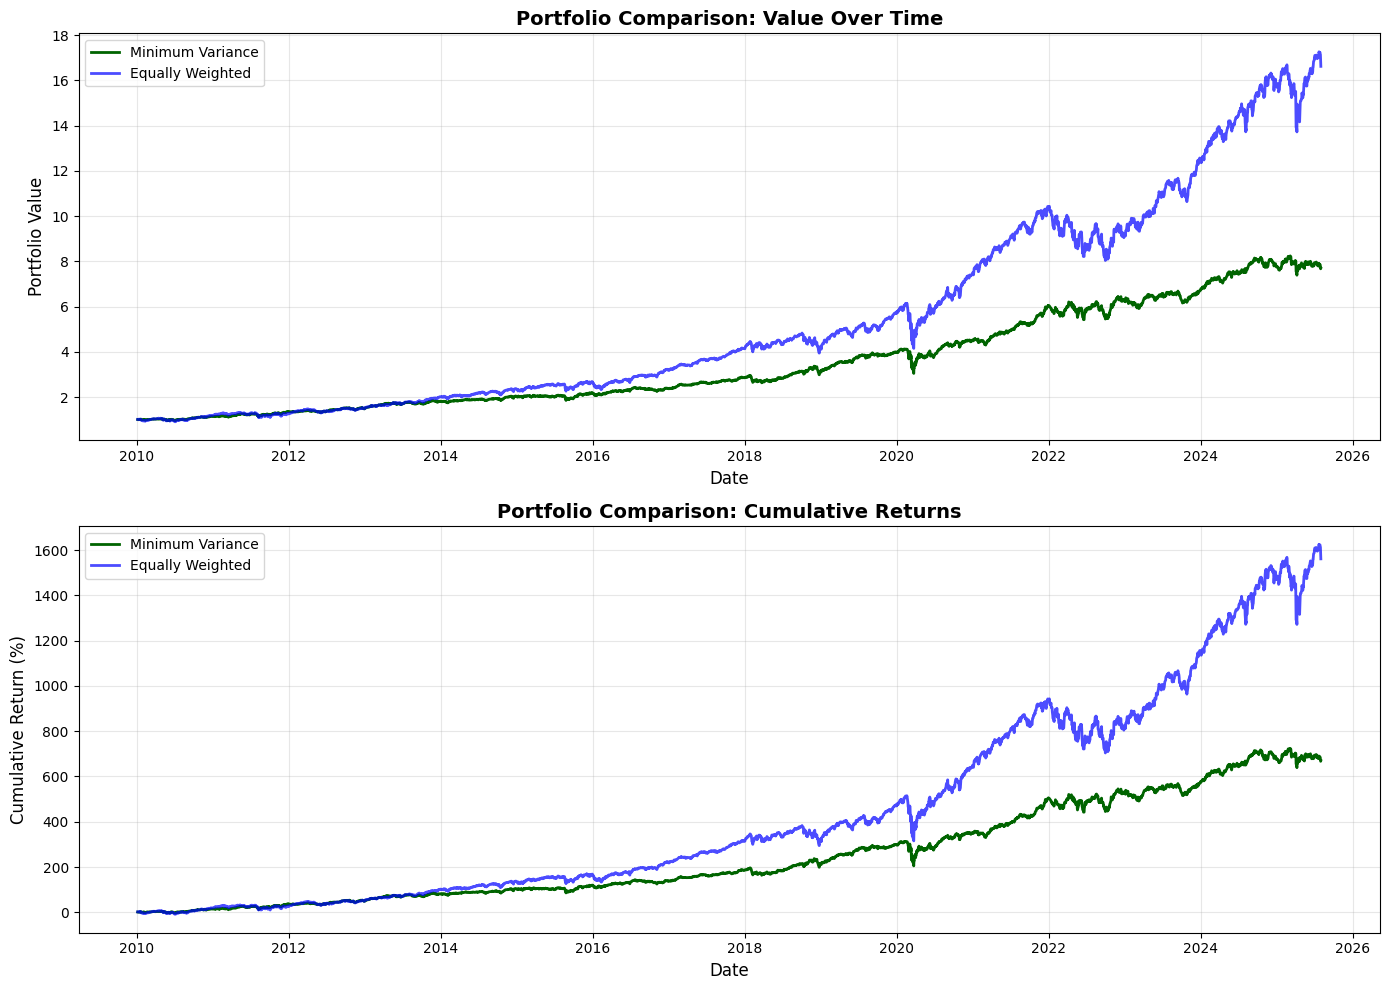

In [53]:
# Plot comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Portfolio values comparison
axes[0].plot(mvo_portfolio.index, mvo_portfolio['Portfolio Value'], 
             label='Minimum Variance', color='darkgreen', linewidth=2)
axes[0].plot(ew_portfolio.index, ew_portfolio['Portfolio Value'], 
             label='Equally Weighted', color='blue', linewidth=2, alpha=0.7)
axes[0].set_title('Portfolio Comparison: Value Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Portfolio Value', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Cumulative returns comparison
axes[1].plot(mvo_portfolio.index, mvo_portfolio['Cumulative Return'] * 100, 
             label='Minimum Variance', color='darkgreen', linewidth=2)
axes[1].plot(ew_portfolio.index, ew_portfolio['Cumulative Return'] * 100, 
             label='Equally Weighted', color='blue', linewidth=2, alpha=0.7)
axes[1].set_title('Portfolio Comparison: Cumulative Returns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Cumulative Return (%)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Rolling Metrics Analysis

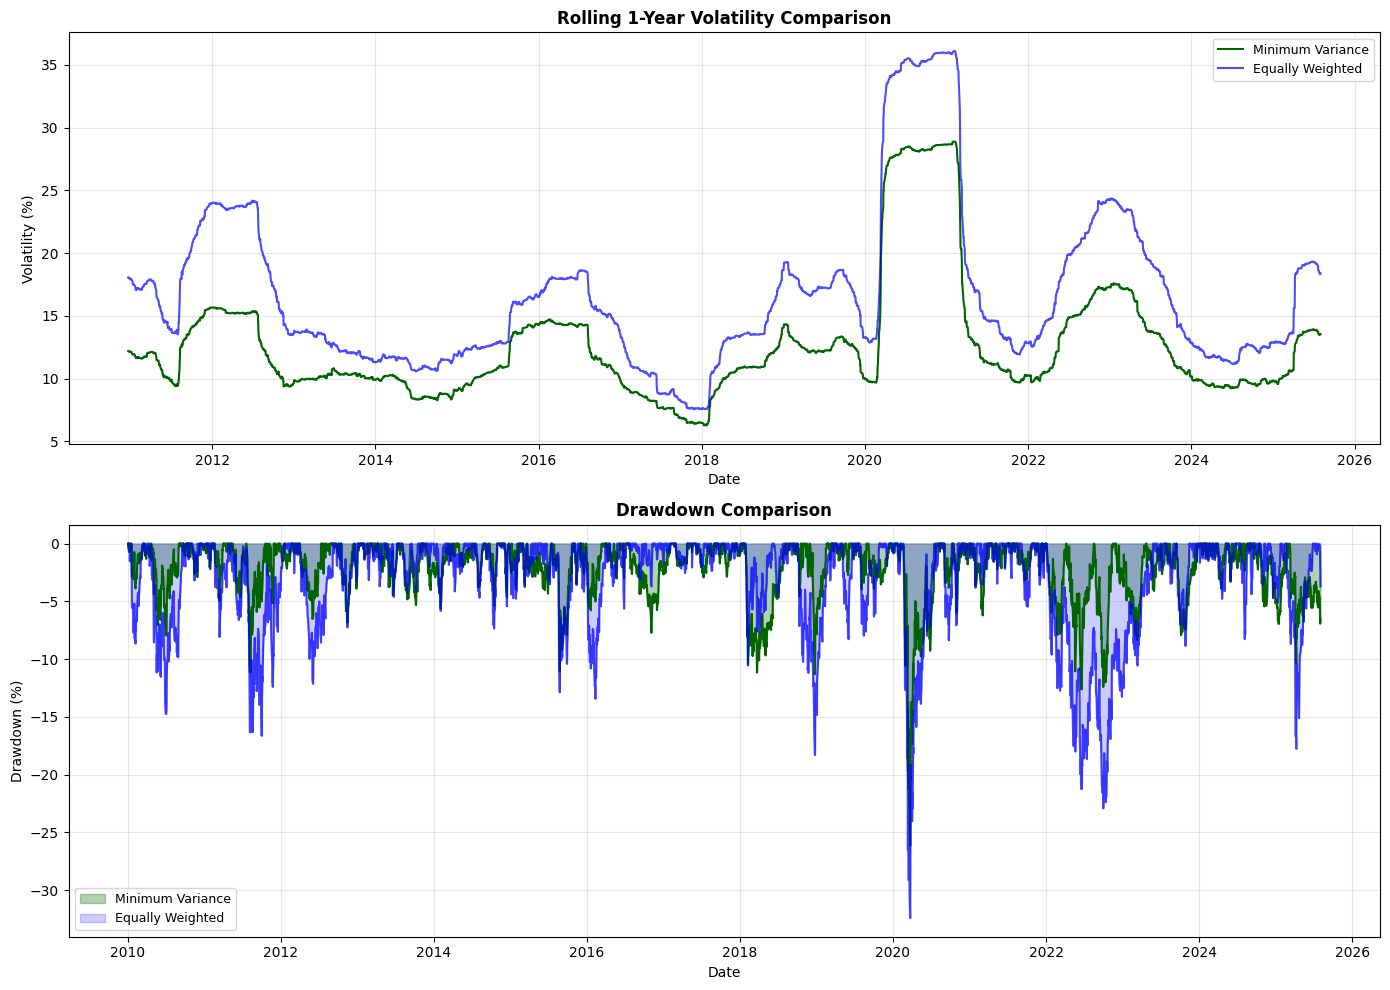

In [54]:
# Calculate rolling metrics
rolling_window = 252

# MVO portfolio
mvo_rolling_returns = mvo_portfolio['Daily Return'].rolling(window=rolling_window)
mvo_rolling_vol = mvo_rolling_returns.std() * (252 ** 0.5)

# EW portfolio
ew_rolling_returns = ew_portfolio['Daily Return'].rolling(window=rolling_window)
ew_rolling_vol = ew_rolling_returns.std() * (252 ** 0.5)

# Drawdowns
mvo_cumulative = (1 + mvo_portfolio['Daily Return']).cumprod()
mvo_running_max = mvo_cumulative.expanding().max()
mvo_drawdown = (mvo_cumulative - mvo_running_max) / mvo_running_max

ew_cumulative = (1 + ew_portfolio['Daily Return']).cumprod()
ew_running_max = ew_cumulative.expanding().max()
ew_drawdown = (ew_cumulative - ew_running_max) / ew_running_max

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Rolling volatility
axes[0].plot(mvo_portfolio.index, mvo_rolling_vol * 100, 
             label='Minimum Variance', color='darkgreen', linewidth=1.5)
axes[0].plot(ew_portfolio.index, ew_rolling_vol * 100, 
             label='Equally Weighted', color='blue', linewidth=1.5, alpha=0.7)
axes[0].set_title('Rolling 1-Year Volatility Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=10)
axes[0].set_ylabel('Volatility (%)', fontsize=10)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Drawdowns
axes[1].fill_between(mvo_portfolio.index, mvo_drawdown * 100, 0, 
                     color='darkgreen', alpha=0.3, label='Minimum Variance')
axes[1].plot(mvo_portfolio.index, mvo_drawdown * 100, 
             color='darkgreen', linewidth=1.5)
axes[1].fill_between(ew_portfolio.index, ew_drawdown * 100, 0, 
                     color='blue', alpha=0.2, label='Equally Weighted')
axes[1].plot(ew_portfolio.index, ew_drawdown * 100, 
             color='blue', linewidth=1.5, alpha=0.7)
axes[1].set_title('Drawdown Comparison', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=10)
axes[1].set_ylabel('Drawdown (%)', fontsize=10)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### Markowitz Minimum Variance Portfolio

This notebook implements **Markowitz Mean-Variance Optimization** to find the portfolio with the minimum variance (lowest risk).

### Key Features:

1. **Optimization Approach**: Uses quadratic programming to minimize portfolio variance subject to:
   - Weights sum to 1 (fully invested)
   - Long-only constraints (no short selling)

2. **Portfolio Characteristics**:
   - Typically concentrates weights in lower-volatility stocks
   - Achieves lower overall portfolio variance than equal weighting
   - May sacrifice some returns for reduced risk

3. **Comparison with Equally Weighted**:
   - **Lower volatility**: MVO portfolio has reduced risk
   - **Risk-adjusted returns**: Better Sharpe ratio in many cases
   - **Concentration**: Fewer stocks with significant weights

### Limitations:

- Based on historical covariance (assumes past relationships continue)
- Sensitive to estimation errors in the covariance matrix
- May result in concentrated portfolios
- Does not guarantee higher returns, only lower variance